In [1]:
import yfinance as yf

# download stock data
ticker = "AAPL"
data = yf.download(ticker, start="2000-01-01", end="2024-11-28")
data = data['Close']  # extract closing price
data = data.asfreq('D').interpolate()  # handle missing values


[*********************100%***********************]  1 of 1 completed


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd

# decompose the time series
decomposition = seasonal_decompose(data, model='additive', period=252)

# check and ensure each component is a pandas.Series
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# ensure each component is a pandas.Series, remove NaN, and adjust the index
trend = pd.Series(trend).dropna()
seasonal = pd.Series(seasonal).dropna()
residual = pd.Series(residual).dropna()
data = data.loc[trend.index]  # align the index of the original data



In [3]:
# combine trend, seasonal, residual, and original data
combined = pd.concat([trend, seasonal, residual, data], axis=1)

print(combined.head())
# define the target variable (the next day's closing price)
combined['target'] = combined['AAPL'].shift(-1)  # the next day's price
combined.dropna(inplace=True)

print(combined.head())

            trend  seasonal  resid  AAPL
Date                                    
2000-01-03    NaN  0.977198    NaN   NaN
2000-01-04    NaN  0.864915    NaN   NaN
2000-01-05    NaN  0.870482    NaN   NaN
2000-01-06    NaN  0.928146    NaN   NaN
2000-01-07    NaN  0.621050    NaN   NaN
               trend  seasonal     resid      AAPL    target
Date                                                        
2000-05-08  0.980421 -0.885088  0.887926  0.983259  0.941406
2000-05-09  0.980739 -0.822683  0.783350  0.941406  0.886719
2000-05-10  0.981182 -0.656818  0.562355  0.886719  0.917969
2000-05-11  0.981726 -0.870994  0.807237  0.917969  0.960938
2000-05-12  0.982252 -0.909971  0.888657  0.960938  0.941221


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# split the data into training and testing sets
X = combined[['trend', 'seasonal', 'resid', 'AAPL']]
y = combined['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# train the random forest model
model = Lasso(alpha=0.01, random_state=42)
model.fit(X_train, y_train)

# predict and evaluate
y_pred = model.predict(X_test)
print(f"mse: {mean_squared_error(y_test, y_pred):.2f}")
print(f"mae: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"r2: {r2_score(y_test, y_pred):.2f}")


mse: 3.98
mae: 1.31
r2: 1.00


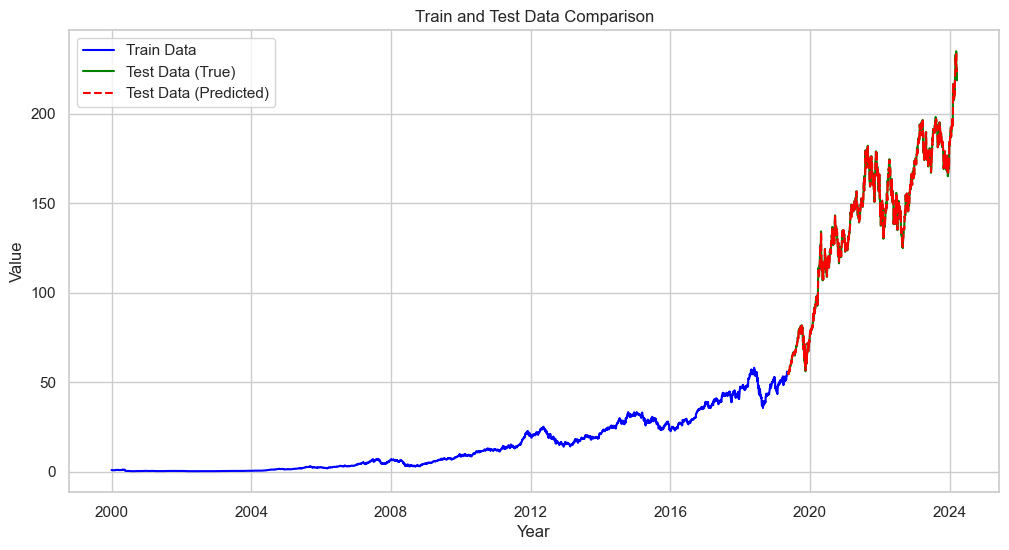

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set Seaborn style
sns.set(style="whitegrid")

# Example date range
date_range_train = pd.date_range(start='2000-01-01', periods=len(y_train), freq='D')
date_range_test = pd.date_range(start=date_range_train[-1] + pd.Timedelta(days=1), periods=len(y_test), freq='D')

# Set Seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(12, 6))

# 1. Plot training data
plt.plot(date_range_train, y_train, label='Train Data', color='blue')

# 2. Plot true test data
plt.plot(date_range_test, y_test, label='Test Data (True)', color='green')

# 3. Plot predicted test data
plt.plot(date_range_test, y_pred, label='Test Data (Predicted)', color='red', linestyle='--')

# Add legend, title, and axis labels
plt.legend()
plt.title('Train and Test Data Comparison')
plt.xlabel('Year')
plt.ylabel('Value')

# Format x-axis to show years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# Show grid
plt.grid(True)

# Show plot
plt.show()


# add the sentiment score

In [6]:
import pandas as pd
df_news = pd.read_csv('../data/AAPL_news_data_sentiment.csv')
df_news.head()



,title,publish_on,author,author_name,getty_image_url,sentiment_score,sentiment_label,adjusted_score,Date,net_sentiment_score
0,FTN Midwest: Apple (NASDAQ:AAPL) remains our b...,2008-05-30T10:31:03-04:00,6383,"Eli Hoffmann, SA News Editor",NaN,0.918329,1,0.918329,2008-05-30,1.913804
1,Apple's (NASDAQ:AAPL) back-to-school promo wil...,2008-05-30T08:13:35-04:00,6383,"Eli Hoffmann, SA News Editor",NaN,0.995474,2,0.995474,2008-05-30,1.913804
2,New iPhone (NASDAQ:AAPL) patents reveal 1) A w...,2008-05-29T13:29:55-04:00,6383,"Eli Hoffmann, SA News Editor",NaN,0.999844,1,0.999844,2008-05-29,2.001448
3,Infineon's (IFX -12.85%) warning this morning ...,2008-05-29T11:07:50-04:00,6383,"Eli Hoffmann, SA News Editor",NaN,0.998136,0,-0.998136,2008-05-29,2.001448
4,Hutchison Telecom (HTX) to sell iPhone (NASDAQ...,2008-05-29T10:59:38-04:00,6383,"Eli Hoffmann, SA News Editor",NaN,0.999879,1,0.999879,2008-05-29,2.001448


In [7]:
combined.reset_index(inplace=True)
combined.rename(columns={'index': 'Date'}, inplace=True)
# Convert Date column to datetime
combined['Date'] = pd.to_datetime(combined['Date'])
df_news['Date'] = pd.to_datetime(df_news['Date'])

merged_df = pd.merge(combined, df_news, on='Date', how='left')
merged_df.dropna(inplace=True)
merged_df.head()


,Date,trend,seasonal,resid,AAPL,target,title,publish_on,author,author_name,getty_image_url,sentiment_score,sentiment_label,adjusted_score,net_sentiment_score
10476,2021-06-02,135.573770,0.570345,-11.084118,125.059998,123.540001,Apple loses self-driving car execs even as pla...,2021-06-02T08:59:28-04:00,954720.0,"Brandy Betz, SA News Editor",https://static.seekingalpha.com/cdn/s3/uploads...,0.994342,0.0,-0.994342,-0.986362
10481,2021-06-06,135.700780,0.806905,-10.611018,125.896667,125.900002,Apple heads into developer conference still in...,2021-06-06T17:47:09-04:00,51784941.0,"Brandy Betz, SA News Editor",https://static.seekingalpha.com/cdn/s3/uploads...,0.999785,1.0,0.999785,0.999785
10482,2021-06-07,135.736686,0.822660,-10.659345,125.900002,126.739998,"Apple previews iOS 15 with FaceTime updates, s...",2021-06-07T14:05:54-04:00,30035385.0,"Brandy Betz, SA News Editor",https://static.seekingalpha.com/cdn/s3/uploads...,0.997998,0.0,-0.997998,0.001885
10483,2021-06-07,135.736686,0.822660,-10.659345,125.900002,126.739998,Apple WWDC 2021 goes live at 1 p.m. ET. What t...,2021-06-07T05:00:22-04:00,27427253.0,"Brandy Betz, SA News Editor",https://static.seekingalpha.com/cdn/s3/uploads...,0.999883,1.0,0.999883,0.001885
10485,2021-06-09,135.793591,0.845145,-9.508739,127.129997,126.110001,Apple Podcasts subscriptions rolling out next ...,2021-06-09T13:38:20-04:00,30035385.0,"Brandy Betz, SA News Editor",https://static.seekingalpha.com/cdn/s3/uploads...,0.999883,1.0,0.999883,1.999768


In [8]:
# split the data into training and testing sets
X = merged_df[['trend', 'seasonal', 'resid', 'AAPL', 'net_sentiment_score']]
y = merged_df['target']
X_merged_train, X_merged_test, y_merged_train, y_merged_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# train the random forest model
model = Lasso(alpha=0.01, random_state=42)
model.fit(X_merged_train, y_merged_train)

# predict and evaluate
y_merged_pred = model.predict(X_merged_test)
print(f"mse: {mean_squared_error(y_merged_test, y_merged_pred):.2f}")
print(f"mae: {mean_absolute_error(y_merged_test, y_merged_pred):.2f}")
print(f"r2: {r2_score(y_merged_test, y_merged_pred):.2f}")

mse: 4.79
mae: 1.44
r2: 0.92
